In [1]:
import pyomo.environ as pyo
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx   #library to model graphs. Cool because can tell you which nodes are neighbours to the other.
from linopy import Model
from itertools import combinations
from pyomo.environ import SolverFactory

In [2]:
#Import data on conductors
conductors_df = pd.read_csv("./cables_types.csv", index_col=0)
conductors = conductors_df.to_xarray().head(2)

#Import data on Buses
Bus_pos_df = pd.read_csv("./buses.csv", index_col=0)
Bus_position = Bus_pos_df.to_xarray()


day = 56
#Import data on days considered.
if day == 56:
    P_demand_df = pd.read_csv("./P_demand_Buses_winter.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_winter.csv",index_col=0)
elif day == 93:
    P_demand_df = pd.read_csv("./P_demand_Buses_spring.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_spring.csv",index_col=0)
elif day == 201:
    P_demand_df = pd.read_csv("./P_demand_Buses_summer.csv",index_col=0)
    Q_demand_df = pd.read_csv("./Q_demand_Buses_xummer.csv",index_col=0)
else:
    print("error : chosen day not in the data.")

P_demand = P_demand_df.to_xarray().head(5)
Q_demand = Q_demand_df.to_xarray().head(5)

    

In [3]:
#Helping functions :
def plot(G, title="Graph"):
    pos = nx.get_node_attributes(G, 'pos')
    if not pos:
        print("No position data found.")
    else:
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, node_size=300, alpha=0.8, arrows=True)
        plt.title(title)
        plt.gca().set_aspect('equal')
        plt.show()

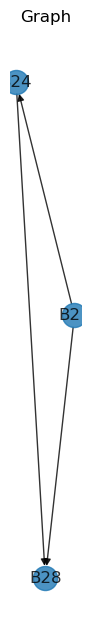

In [4]:
#Bus geometry implementation
Bus_ID = Bus_position["Building ID"].values
X = Bus_position["X"].values/100
Y = - Bus_position["Y"].values/100
network_voltage = Bus_position["Voltage"].values
zone = Bus_position["zone"].values

G_04_Hochelaga = nx.DiGraph()
for i in range(len(Bus_ID)):
    bus_id = Bus_ID[i]
    pos = (X[i], Y[i])
    voltage = network_voltage[i]
    current_zone = zone[i]
    if voltage == 0.4 and current_zone == "Hochelaga":
        G_04_Hochelaga.add_node(bus_id, P=0.0, pos=pos)



        # Add edges between all nodes 
for u, v in combinations(G_04_Hochelaga.nodes, 2):
    G_04_Hochelaga.add_edge(u, v)
    
plot(G_04_Hochelaga)

In [5]:
list(G_04_Hochelaga.nodes)[0]

'B22'

In [6]:
### Sets
time = P_demand.get_index("Date/Time")


# Lines
line_list = list(G_04_Hochelaga.edges)
line_index = pd.MultiIndex.from_tuples(line_list, names=["from_bus", "to_bus"])
lines = xr.DataArray(
    data=line_index,  # dummy values are fine here, just to match shape
    coords={"Lines": line_index},
    dims="Lines"
)
from_bus = xr.DataArray(
    line_index.get_level_values("from_bus"),
    coords={"Lines": lines.coords["Lines"]},  # original Lines coord
    dims="Lines"
)

to_bus = xr.DataArray(
    line_index.get_level_values("to_bus"),
    coords={"Lines": lines.coords["Lines"]},
    dims="Lines"
)

# Buses and substation
buses = pd.Index(G_04_Hochelaga.nodes, name = "Buses")
buses = xr.DataArray(buses, dims="Buses", name="Buses")
is_substation = pd.Series(buses.isin(['B22']), index=buses, name='is_substation') #Choisi manuellement dans un premier temps
substation_xr = xr.DataArray(is_substation, coords=[buses])
substations = substation_xr.where(substation_xr, drop=True).coords["Buses"].values
substations = xr.DataArray(substations, dims="Substations", name="Substations")
#Conductors
types = conductors.get_index("Conductor_type")
### Parameters
# Time related
PLANNING_HORIZON = 20 
HOURS_PER_YEAR = 8760

# Cost related

TAUL =  0.05             
TAUS =  0.05     

KC = 0.08                 
KL = (TAUL * (TAUL+1)**PLANNING_HORIZON)/(((TAUL+1)**PLANNING_HORIZON) -1)                  
KS= (TAUS * (TAUS+1)**PLANNING_HORIZON)/(((TAUS+1)**PLANNING_HORIZON) -1)                   # vient de i(i+1)^n/((i+1)^n -1)
               
CF = 1000               # paper data
CSI = 350000               # false data
CVI = 1e-5               # false data
CUN  = 500              # false data
CK  = 100000              # false data
CL = 0.0781                # false data


# type related
R = conductors['Resistance']
X = conductors['Reactance']
Z = R**2 + X**2
cost_line = conductors['Prix_au_km']

# Line related
positions = nx.get_node_attributes(G_04_Hochelaga, "pos")
edge_lengths = []
for i,j in G_04_Hochelaga.edges:
    xi, yi = positions[i]
    xj, yj = positions[j]
    length = np.sqrt((xi - xj)**2 + (yi - yj)**2)
    edge_lengths.append((i,j,length))
line_index = pd.MultiIndex.from_tuples([(i, j) for i, j, _ in edge_lengths], names=["from_bus", "to_bus"])
lengths = [length for _, _, length in edge_lengths]
LENGTH = xr.DataArray(lengths, coords={"Lines": line_index},dims="Lines", name="line_length")


# Voltage related
V_MIN = 0.360
V_MAX = 0.440
B_MAX = 0.08

# Current related
I_MAX = conductors['I_MAX']

# Capacitor related
N_CAP_MAX = 100                # false data
N_CAP_TOTAL = 10e6               # false data
Q_PER_CAP = 1e6                      # e.g., 1 MVAr per unit

# Power related
SG = 10e6                   # false data
CS = 215*SG

P_D_LIST = []
Q_D_LIST = []
for i in buses.values:
    P_D_LIST.append((i, P_demand[i]))
    Q_D_LIST.append((i, Q_demand[i]))
P_D_dict = {bus: da for bus, da in P_D_LIST}
Q_D_dict = {bus: da for bus, da in Q_D_LIST}
# Convert to a single DataArray with stacked dimension: (Bus, Date/Time)
P_DEMAND = xr.concat(P_D_dict.values(), dim=pd.Index(P_D_dict.keys(), name="Buses"))
Q_DEMAND = xr.concat(Q_D_dict.values(), dim=pd.Index(Q_D_dict.keys(), name="Buses"))


P_GEN = xr.zeros_like(P_DEMAND)
p_charge = xr.zeros_like(P_DEMAND)
p_discharge = xr.zeros_like(P_DEMAND)

In [7]:
print(buses.values)

['B22' 'B24' 'B28']


In [8]:
# ### Sets --------------------------------------------------------------------

# Dans Pyomo, on déclare des ensembles comme suit. Vous pouvez
# les remplir avec les données extraites de vos DataFrame ou xarray DataArray.

# Exemple d'initialisation des ensembles (à adapter selon vos données réelles) :

time_set = list(time)  # par exemple, time peut être un pd.Index, converti en liste
line_list = list(zip(from_bus.values, to_bus.values))  # si vous avez déjà un MultiIndex
bus_list = list(buses.values)
substation_list = list(substations.values)
type_list = list(types.values)

# Création du modèle Pyomo
model = pyo.ConcreteModel("Hochelaga_Distribution_Network")

# Déclaration des ensembles
model.Time = pyo.Set(initialize=time_set, ordered=True)
model.Buses = pyo.Set(initialize=bus_list)
model.Substations = pyo.Set(initialize=substation_list)
model.Lines = pyo.Set(initialize=line_list, dimen=2)  # (from_bus, to_bus)
model.Types = pyo.Set(initialize=type_list)


In [9]:
print(P_DEMAND.coords["Date/Time"].values)
print(Q_DEMAND.coords["Date/Time"].values)
print(time_set)

[' 02/25  01:00:00' ' 02/25  02:00:00' ' 02/25  03:00:00'
 ' 02/25  04:00:00' ' 02/25  05:00:00']
[' 02/25  01:00:00' ' 02/25  02:00:00' ' 02/25  03:00:00'
 ' 02/25  04:00:00' ' 02/25  05:00:00']
[' 02/25  01:00:00', ' 02/25  02:00:00', ' 02/25  03:00:00', ' 02/25  04:00:00', ' 02/25  05:00:00']


In [10]:


# ### Paramètres --------------------------------------------------------------
# Paramètres scalaires
model.PLANNING_HORIZON = pyo.Param(initialize=20, mutable=True)
model.HOURS_PER_YEAR = pyo.Param(initialize=8760, mutable=True)

model.TAUL = pyo.Param(initialize=0.05, mutable=True)
model.TAUS = pyo.Param(initialize=0.05, mutable=True)

model.KC = pyo.Param(initialize=0.08, mutable=True)
model.CF = pyo.Param(initialize=1000, mutable=True)
model.CSI = pyo.Param(initialize=350000, mutable=True)
model.CVI = pyo.Param(initialize=1e-5, mutable=True)
model.cost_line = pyo.Param(initialize=100000, mutable=True)
model.CUN = pyo.Param(initialize=500, mutable=True)
model.CK = pyo.Param(initialize=100000, mutable=True)
model.CL = pyo.Param(initialize=0.0781, mutable=True)

model.V_MIN = pyo.Param(initialize=0.360, mutable=True)
model.V_MAX = pyo.Param(initialize=0.440, mutable=True)
model.B_MAX = pyo.Param(initialize=0.08, mutable=True)

model.N_CAP_MAX = pyo.Param(initialize=100, mutable=True)
model.N_CAP_TOTAL = pyo.Param(initialize=1e7, mutable=True)  # ex: 10e6
model.Q_PER_CAP = pyo.Param(initialize=1e6, mutable=True)     # ex: 1 MVAr/unité

model.SG = pyo.Param(initialize=1e7, mutable=True)     # ex: 10e6
model.CS = pyo.Param(initialize=215e7, mutable=True)    # 215*SG (ex. 215*1e7)

# Paramètres indexés par Types (R, X, Z, I_MAX, etc.)
# Exemple : conductors['Resistance'] = R (dict)...
# Adaptez la construction des dict selon vos arrays
R_dict = dict(zip(model.Types, R.values))
X_dict = dict(zip(model.Types, X.values))
Z_dict = dict(zip(model.Types, Z.values))
Imax_dict = dict(zip(model.Types, I_MAX.values))
cost_line_dict = dict(zip(model.Types, cost_line.values))

model.R = pyo.Param(model.Types, initialize=R_dict, mutable=True)
model.X = pyo.Param(model.Types, initialize=X_dict, mutable=True)
model.Z = pyo.Param(model.Types, initialize=Z_dict, mutable=True)
model.I_MAX = pyo.Param(model.Types, initialize=Imax_dict, mutable=True)
model.cost_line = pyo.Param(model.Types, initialize=cost_line_dict, mutable=True)

# Paramètre indexé par Lines : LENGTH
length_dict = dict(zip(line_list, LENGTH.values))
model.LENGTH = pyo.Param(model.Lines, initialize=length_dict, mutable=True)

# Paramètres liés à la demande (par bus, par pas de temps).
# Dans Linopy : P_DEMAND[b, t], Q_DEMAND[b, t].
# On crée des dictionnaires {(b, t): value} pour Pyomo.
P_DEMAND_dict = {}
Q_DEMAND_dict = {}

for b in bus_list:
    for t in time_set:
        P_DEMAND_dict[(b, t)] = float(P_DEMAND.sel(Buses=b).sel(**{"Date/Time": t}))
        Q_DEMAND_dict[(b, t)] = float(Q_DEMAND.sel(Buses=b).sel(**{"Date/Time": t}))

model.P_DEMAND = pyo.Param(model.Buses, model.Time, initialize=P_DEMAND_dict, mutable=True)
model.Q_DEMAND = pyo.Param(model.Buses, model.Time, initialize=Q_DEMAND_dict, mutable=True)

# Si vous avez P_GEN, p_charge, p_discharge identiques (zéros), créez-les également
# comme paramètres indexés pour simplifier (ou on peut les laisser en variable à 0).
P_GEN_dict = {}
p_charge_dict = {}
p_discharge_dict = {}
for b in bus_list:
    for t in time_set:
        P_GEN_dict[(b, t)] = float(P_GEN.sel(Buses=b).sel(**{"Date/Time": t}))
        p_charge_dict[(b, t)] = float(p_charge.sel(Buses=b).sel(**{"Date/Time": t}))
        p_discharge_dict[(b, t)] = float(p_discharge.sel(Buses=b).sel(**{"Date/Time": t}))

model.P_GEN = pyo.Param(model.Buses, model.Time, initialize=P_GEN_dict, mutable=True)
# model.p_charge = pyo.Param(model.Buses, model.Time, initialize=p_charge_dict, mutable=True)
# model.p_discharge = pyo.Param(model.Buses, model.Time, initialize=p_discharge_dict, mutable=True)


'pyomo.core.base.param.ScalarParam'>) on block Hochelaga_Distribution_Network
with a new Component (type=<class 'pyomo.core.base.param.IndexedParam'>). This
is usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


In [11]:
print(cost_line)

<xarray.DataArray 'Prix_au_km' (Conductor_type: 2)> Size: 16B
array([4170, 1390])
Coordinates:
  * Conductor_type  (Conductor_type) object 16B '243-AL1/39-ST1A 20.0' 'NAVY ...


In [12]:
# ### Variables ---------------------------------------------------------------
# On reproduit les variables du modèle Linopy en version Pyomo, avec les bons domaines.

# i_squared_cond(lines, time, types)
model.i_squared_cond = pyo.Var(model.Lines, model.Time, model.Types, domain=pyo.NonNegativeReals)

# i_squared(lines, time)
model.i_squared = pyo.Var(model.Lines, model.Time, domain=pyo.NonNegativeReals)

I2_max = max(model.I_MAX[t]**2 for t in model.Types)
model.i_squared.setub(I2_max)
model.i_squared_cond.setub(I2_max)

# v_squared(buses, time)
model.v_squared = pyo.Var(model.Buses, model.Time, domain=pyo.NonNegativeReals)

# s_sub_squared(substations, time)
model.s_sub_squared = pyo.Var(model.Substations, model.Time, domain=pyo.NonNegativeReals)

# p_flow(lines, time, types)
model.p_flow = pyo.Var(model.Lines, model.Time, model.Types, domain=pyo.Reals)
# q_flow(lines, time, types)
model.q_flow = pyo.Var(model.Lines, model.Time, model.Types, domain=pyo.Reals)

# p_flow_total(lines, time)
model.p_flow_total = pyo.Var(model.Lines, model.Time, domain=pyo.Reals)
# q_flow_total(lines, time)
model.q_flow_total = pyo.Var(model.Lines, model.Time, domain=pyo.Reals)

# p_sub(substations, time)
model.p_sub = pyo.Var(model.Substations, model.Time, domain=pyo.NonNegativeReals)
# q_sub(substations, time)
model.q_sub = pyo.Var(model.Substations, model.Time, domain=pyo.NonNegativeReals)

# voltage_drop_term(lines)
model.voltage_drop_term = pyo.Var(model.Lines, model.Time, domain=pyo.Reals)

# n_cap(buses) -> entier
model.n_cap = pyo.Var(model.Buses, domain=pyo.NonNegativeIntegers)
# q_cap_installed(buses) -> binaire
model.q_cap_installed = pyo.Var(model.Buses, domain=pyo.Binary)

# y_pos(lines, time) -> binaire
model.y_pos = pyo.Var(model.Lines, model.Time, domain=pyo.Binary)
# y_neg(lines, time) -> binaire
model.y_neg = pyo.Var(model.Lines, model.Time, domain=pyo.Binary)

# z(lines, types) -> binaire
model.z = pyo.Var(model.Lines, model.Types, domain=pyo.Binary)

# w(substations) -> binaire
model.w = pyo.Var(model.Substations, domain=pyo.Binary)




In [13]:
# ### Contraintes -------------------------------------------------------------
#
# Ci-dessous, on recrée l’ensemble des contraintes Linopy. Pour gérer des
# "groupby(to_bus).sum(...) - groupby(from_bus).sum(...)", on peut :
# 1) Extraire la liste des lines sortant de chaque bus, et entrants de chaque bus.
# 2) Boucler sur chaque bus/time.

# 1) Dictionnaires pour récupérer lines entrant/sortant par bus
from collections import defaultdict

outgoing_lines_by_bus = defaultdict(list)
incoming_lines_by_bus = defaultdict(list)
for (fb, tb) in model.Lines:
    outgoing_lines_by_bus[fb].append((fb, tb))
    incoming_lines_by_bus[tb].append((fb, tb))

# --- Active Power Balance Constraint ---
def active_power_balance_rule(m, b, t):
    # Somme des p_flow entrants - somme des p_flow sortants
    in_sum = sum(m.p_flow[(l, t, typ)] 
                 for l in incoming_lines_by_bus[b]
                 for typ in m.Types)
    out_sum = sum(m.p_flow[(l, t, typ)] + m.R[typ] * m.LENGTH[(fb, tb)] * m.i_squared_cond[( (fb, tb), t, typ )]
                  for l in outgoing_lines_by_bus[b] 
                  for typ in m.Types)
    # Sous-station si b est substation
    p_sub_part = m.p_sub[b, t] if b in m.Substations else 0.0
    # P_GEN, p_charge, p_discharge
    p_gen_part = m.P_GEN[b, t]
    #p_charge_part = m.p_charge[b, t]
    #p_discharge_part = m.p_discharge[b, t]

    return in_sum - out_sum + p_sub_part + p_gen_part  == m.P_DEMAND[b, t] #- p_charge_part + p_discharge_part

model.ActivePowerBalance = pyo.Constraint(model.Buses, model.Time, rule=active_power_balance_rule)

# --- Reactive Power Balance Constraint ---
def reactive_power_balance_rule(m, b, t):
    in_sum = sum(m.q_flow[(l, t, typ)] 
                 for l in incoming_lines_by_bus[b]
                 for typ in m.Types)
    out_sum = sum(m.q_flow[(l, t, typ)] + m.X[typ] * m.LENGTH[(fb, tb)] * m.i_squared_cond[( (fb, tb), t, typ )]
                  for l in outgoing_lines_by_bus[b]
                  for typ in m.Types)
    q_sub_part = m.q_sub[b, t] if b in m.Substations else 0.0
    # Ajout Q_PER_CAP * n_cap
    return in_sum - out_sum + q_sub_part + m.Q_PER_CAP * m.n_cap[b] == m.Q_DEMAND[b, t]

model.ReactivePowerBalance = pyo.Constraint(model.Buses, model.Time, rule=reactive_power_balance_rule)

# --- Voltage drop ---
# V_from - V_to == voltage_drop_term + ...
# Il faut le faire pour CHAQUE pas de temps.  
def voltage_drop_per_t_rule(m, fb, tb, t):
    # V_from - V_to
    v_from = m.v_squared[fb, t]
    v_to = m.v_squared[tb, t]
    # drop_expr (somme sur "Types")
    drop_expr = sum(
        2 * (m.R[typ] * m.p_flow[( (fb, tb), t, typ )] + 
             m.X[typ] * m.q_flow[( (fb, tb), t, typ )]) * m.LENGTH[(fb, tb)]
        + (m.Z[typ]) * (m.LENGTH[(fb, tb)]**2) * m.i_squared_cond[( (fb, tb), t, typ )]
        for typ in m.Types
    )
    # On ne crée pas un big index (fb, tb, t, typ), donc on fait la somme sur typ ici
    return v_from - v_to == m.voltage_drop_term[(fb, tb),t] + drop_expr

# On a deux façons : 
# 1) Soit on créé un ConstraintList, 
# 2) Soit un constraint sur Lines x Time
model.VoltageDrop = pyo.Constraint(model.Lines, model.Time, rule=voltage_drop_per_t_rule)

# --- Voltage bounds ---
def voltage_min_rule(m, b, t):
    return m.v_squared[b, t] >= m.V_MIN**2

def voltage_max_rule(m, b, t):
    return m.v_squared[b, t] <= m.V_MAX**2

model.VoltageMin = pyo.Constraint(model.Buses, model.Time, rule=voltage_min_rule)
model.VoltageMax = pyo.Constraint(model.Buses, model.Time, rule=voltage_max_rule)

# --- Voltage drop limit using big-M ---
# voltage_drop_term <= B_MAX * (-(y_pos + y_neg -1)), etc.
# Dans Linopy, on a m.add_constraints(voltage_drop_term <= B_MAX * (-(y_pos + y_neg -1)))
# Cela demande un soin particulier; on reproduit la logique si besoin.
def voltage_drop_term_pos_rule(m, fb, tb, t):
    return m.voltage_drop_term[(fb, tb),t] <= m.B_MAX * (-(m.y_pos[(fb, tb), t] + m.y_neg[(fb, tb), t] - 1))

def voltage_drop_term_neg_rule(m, fb, tb, t):
    return m.voltage_drop_term[(fb, tb),t] >= -m.B_MAX * (-(m.y_pos[(fb, tb), t] + m.y_neg[(fb, tb), t] - 1))

model.VoltageDropTermPos = pyo.Constraint(model.Lines, model.Time, rule=voltage_drop_term_pos_rule)
model.VoltageDropTermNeg = pyo.Constraint(model.Lines, model.Time, rule=voltage_drop_term_neg_rule)



# --- Current limit with active line ---
# i_squared_cond <= I_MAX^2 * (y_pos + y_neg)
def current_limit_active_rule(m, fb, tb, t, typ):
    return m.i_squared_cond[( (fb, tb), t, typ )] <= m.I_MAX[typ]**2 * (m.y_pos[(fb, tb), t] + m.y_neg[(fb, tb), t])

model.CurrentLimitActive = pyo.Constraint(model.Lines, model.Time, model.Types, rule=current_limit_active_rule)

# --- Current limit with selected conductor ---
# i_squared_cond <= I_MAX^2 * z
def current_limit_conductor_rule(m, fb, tb, t, typ):
    return m.i_squared_cond[( (fb, tb), t, typ )] <= m.I_MAX[typ]**2 * m.z[(fb, tb), typ]

model.CurrentLimitConductor = pyo.Constraint(model.Lines, model.Time, model.Types, rule=current_limit_conductor_rule)



# --- Quadratic relation pour power flow, si besoin ---
"""
def quad_rule(m, fb, tb, t):
    
    return (
        m.v_squared[tb, t] * m.i_squared[(fb, tb), t]
        >= m.p_flow_total[(fb, tb), t]**2 + m.q_flow_total[(fb, tb), t]**2
    )

model.SOCP_Constraint = pyo.Constraint(model.Lines, model.Time, rule=quad_rule)
"""

### 6.  Contrainte SOC correcte
def apparent_power_rule(m, fb, tb, t):
    return m.p_flow_total[fb,tb,t]**2 + m.q_flow_total[fb,tb,t]**2 \
           <= m.V_MAX**2 * m.i_squared[fb,tb,t]   # ou I_MAX² directement




# --- Power flow bounds with direction ---
# p_flow <= V_MAX * I_MAX * y_pos, etc.
def p_flow_dir_rule_1(m, fb, tb, t, typ):
    return m.p_flow[( (fb, tb), t, typ )] <= m.V_MAX * m.I_MAX[typ] * m.y_pos[(fb, tb), t]

def p_flow_dir_rule_2(m, fb, tb, t, typ):
    return m.p_flow[( (fb, tb), t, typ )] >= -m.V_MAX * m.I_MAX[typ] * m.y_neg[(fb, tb), t]

def q_flow_dir_rule_1(m, fb, tb, t, typ):
    return m.q_flow[( (fb, tb), t, typ )] <= m.V_MAX * m.I_MAX[typ] * (m.y_pos[(fb, tb), t] + m.y_neg[(fb, tb), t])

def q_flow_dir_rule_2(m, fb, tb, t, typ):
    return m.q_flow[( (fb, tb), t, typ )] >= -m.V_MAX * m.I_MAX[typ] * (m.y_pos[(fb, tb), t] + m.y_neg[(fb, tb), t])

model.pFlowDir1 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=p_flow_dir_rule_1)
model.pFlowDir2 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=p_flow_dir_rule_2)
model.qFlowDir1 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=q_flow_dir_rule_1)
model.qFlowDir2 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=q_flow_dir_rule_2)

# --- Power flow limit with conductor ---
def p_flow_cond_rule_1(m, fb, tb, t, typ):
    return m.p_flow[( (fb, tb), t, typ )] <= m.V_MAX * m.I_MAX[typ] * m.z[(fb, tb), typ]

def p_flow_cond_rule_2(m, fb, tb, t, typ):
    return m.p_flow[( (fb, tb), t, typ )] >= -m.V_MAX * m.I_MAX[typ] * m.z[(fb, tb), typ]

def q_flow_cond_rule_1(m, fb, tb, t, typ):
    return m.q_flow[( (fb, tb), t, typ )] <= m.V_MAX * m.I_MAX[typ] * m.z[(fb, tb), typ]

def q_flow_cond_rule_2(m, fb, tb, t, typ):
    return m.q_flow[( (fb, tb), t, typ )] >= -m.V_MAX * m.I_MAX[typ] * m.z[(fb, tb), typ]

model.pFlowCond1 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=p_flow_cond_rule_1)
model.pFlowCond2 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=p_flow_cond_rule_2)
model.qFlowCond1 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=q_flow_cond_rule_1)
model.qFlowCond2 = pyo.Constraint(model.Lines, model.Time, model.Types, rule=q_flow_cond_rule_2)

# --- Substation apparent power constraint ---
def s_sub_squared_min_rule(m, s, t):
    # s_sub_squared >= p_sub^2 + q_sub^2
    # Dans Pyomo, on peut lineariser ou on introduit un big-M. 
    # Si on autorise un solveur non-linéaire/quadratique, on fait directement :
    return m.s_sub_squared[s, t] >= m.p_sub[s, t]**2 + m.q_sub[s, t]**2

model.SubstationApparentMin = pyo.Constraint(model.Substations, model.Time, rule=s_sub_squared_min_rule)

# --- Substation capacity limit ---
def s_sub_squared_cap_rule(m, s, t):
    return m.s_sub_squared[s, t] <= m.SG**2 * m.w[s]

model.SubstationCap = pyo.Constraint(model.Substations, model.Time, rule=s_sub_squared_cap_rule)


# --- Capacitor constraints ---
def cap_install_rule(m, b):
    return m.n_cap[b] <= m.N_CAP_MAX * m.q_cap_installed[b]

model.CapInstall = pyo.Constraint(model.Buses, rule=cap_install_rule)

def cap_total_rule(m):
    return sum(m.q_cap_installed[b] for b in m.Buses) <= m.N_CAP_TOTAL

model.CapTotal = pyo.Constraint(rule=cap_total_rule)



# --- Total current = sum des conducteurs ---
def total_current_rule(m, fb, tb, t):
    return m.i_squared[(fb, tb), t] == sum(m.i_squared_cond[( (fb, tb), t, typ )] for typ in m.Types)

model.TotalCurrent = pyo.Constraint(model.Lines, model.Time, rule=total_current_rule)

# --- Total active power = sum des conducteurs ---
def total_p_flow_rule(m, fb, tb, t):
    return m.p_flow_total[(fb, tb), t] == sum(m.p_flow[( (fb, tb), t, typ )] for typ in m.Types)

model.TotalPFlow = pyo.Constraint(model.Lines, model.Time, rule=total_p_flow_rule)

# --- Total reactive power = sum des conducteurs ---
def total_q_flow_rule(m, fb, tb, t):
    return m.q_flow_total[(fb, tb), t] == sum(m.q_flow[( (fb, tb), t, typ )] for typ in m.Types)

model.TotalQFlow = pyo.Constraint(model.Lines, model.Time, rule=total_q_flow_rule)



# --- One direction only per line ---
def one_direction_rule(m, fb, tb, t):
    return m.y_pos[(fb, tb), t] + m.y_neg[(fb, tb), t] <= 1

model.OneDirection = pyo.Constraint(model.Lines, model.Time, rule=one_direction_rule)

# --- Radiality: total active lines = buses - substations ---
def radiality_rule(m, t):
    return sum(m.y_pos[l, t] + m.y_neg[l, t] for l in m.Lines) \
           == (len(bus_list) - len(substation_list))

model.Radiality = pyo.Constraint(model.Time, rule=radiality_rule)

"""
# --- Unique conductor per line if line is active ---
def one_conductor_per_line_rule(model, fb, tb, t):
    return sum(model.z[(fb, tb), typ] for typ in model.Types) == model.y_pos[(fb, tb),t] + model.y_neg[(fb, tb),t]
    

model.OneConductorPerLine = pyo.Constraint(model.Lines, model.Time, rule=one_conductor_per_line_rule)
"""
# (a) jamais plus d’un conducteur statique
model.OneConductorPerLine = pyo.Constraint(
    model.Lines,
    rule=lambda m,i,j:
        sum(m.z[i,j,typ] for typ in m.Types) <= 1
)

# (b) activation ⇒ conducteur existant
def link_activation_conductor(m, i, j, t):
    return m.y_pos[i,j,t] + m.y_neg[i,j,t] \
           <= sum(m.z[i,j,typ] for typ in m.Types)

model.LinkActivationConductor = pyo.Constraint(
    model.Lines, model.Time, rule=link_activation_conductor
)
#(a) garantit qu’on ne peut pas construire deux types de câbles différents sur la même liaison.
#(b) empêche la mise en service d’une ligne si aucun conducteur n’a été installé.

In [14]:
# ### Fonction objectif -------------------------------------------------------

# Calcul du CRF
CRF_S = (1.0 - (1.0 + model.TAUS)**(-model.PLANNING_HORIZON)) / model.TAUS
CRF_L = (1.0 - (1.0 + model.TAUL)**(-model.PLANNING_HORIZON)) / model.TAUL

# --- Substation cost ---
def substation_cost_rule(m):
    KS_value = (m.TAUS * (m.TAUS+1)**m.PLANNING_HORIZON)/(((m.TAUS+1)**m.PLANNING_HORIZON) -1)
    cost1 = sum(KS_value * m.CSI * m.w[s] for s in m.Substations)
    cost2 = sum((m.HOURS_PER_YEAR / 72.0) * CRF_S * m.CVI * m.s_sub_squared[s, t]
                for s in m.Substations for t in m.Time)
    return cost1 + cost2

# --- Line cost ---
def line_cost_rule(m):
    KL_value = (m.TAUL * (m.TAUL+1)**m.PLANNING_HORIZON)/(((m.TAUL+1)**m.PLANNING_HORIZON) - 1)
    cost = sum( m.LENGTH[l] * (KL_value * m.cost_line[typ] * m.z[l, typ] 
               +(m.HOURS_PER_YEAR / 72.0) * CRF_L  * m.R[typ] * m.CL 
               * sum( m.i_squared_cond[l, t, typ] for t in m.Time))
               for typ in m.Types for l in m.Lines)
    return cost

# --- Capacitor cost ---
def capacitor_cost_rule(m):
    return sum(m.CK * m.q_cap_installed[b] + m.CUN * m.n_cap[b] for b in m.Buses)

def objective_rule(m):
    return substation_cost_rule(m) + line_cost_rule(m) + capacitor_cost_rule(m)

model.OBJ = pyo.Objective(rule=objective_rule, sense=pyo.minimize)


In [15]:
# ### Résolution --------------------------------------------------------------
# On utilise SolverFactory("gurobi") par exemple, en activant le mode LP/MILP/MIQP selon besoin.
"""
solver = pyo.SolverFactory("gurobi")  # ou cplex, ipopt, etc.
results = solver.solve(model, tee=True)
"""

'\nsolver = pyo.SolverFactory("gurobi")  # ou cplex, ipopt, etc.\nresults = solver.solve(model, tee=True)\n'

In [17]:
# 1) export LP dans /mnt/data
model.write('model.lp', io_options={'symbolic_solver_labels': True})

# 2) charger et résoudre
import gurobipy as gp
g = gp.read('model.lp')
g.setParam('IISMethod', 1)
g.optimize()

if g.status == gp.GRB.INFEASIBLE:
    g.computeIIS()
    # 3) écriture de l’IIS à l’endroit que vous voulez
    g.write('model_IIS.ilp')
    print("IIS écrit dans /mnt/data/model_IIS.ilp")


Read LP format model from file model.lp
Reading time = 0.00 seconds
OBJ: 497 rows, 223 columns, 1410 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Gold 6354 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Academic license 2551043 - for non-commercial use only - registered to p.___@uliege.be
Optimize a model with 497 rows, 223 columns and 1410 nonzeros
Model fingerprint: 0xd901cf01
Model has 20 quadratic constraints
Variable types: 180 continuous, 43 integer (40 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+14]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e-02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-02, 1e+07]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 34 rows and 6 column

AttributeError: 'gurobipy.Constr' object has no attribute 'RHSSlack'

\ Model OBJ_copy
\ LP format - for model browsing. Use MPS format to capture full model detail.
\ Signature: 0xcdca969c9eb71872
Minimize
 
Subject To
 c_e_ActivePowerBalance(B24___02_25__01_00_00_)_:
   - 0.0202309110027206 i_squared_cond(B24_B28___02_25__01_00_00___243_AL1_39_ST1A_20_0_)
   - 0.1093286604692475 i_squared_cond(B24_B28___02_25__01_00_00__NAVY_4x50_SE)
   + p_flow(B22_B24___02_25__01_00_00___243_AL1_39_ST1A_20_0_)
   + p_flow(B22_B24___02_25__01_00_00__NAVY_4x50_SE)
   - p_flow(B24_B28___02_25__01_00_00___243_AL1_39_ST1A_20_0_)
   - p_flow(B24_B28___02_25__01_00_00__NAVY_4x50_SE) = 10.86941701
 c_e_VoltageDrop(B22_B24___02_25__01_00_00_)_:
   - 7.9229139199999733e-04 i_squared_cond(B22_B24___02_25__01_00_00___243_AL1_39_ST1A_20_0_)
   - 0.00284956039999999 i_squared_cond(B22_B24___02_25__01_00_00__NAVY_4x50_SE)
   - 0.0195929979329351 p_flow(B22_B24___02_25__01_00_00___243_AL1_39_ST1A_20_0_)
   - 0.1058813524658613 p_flow(B22_B24___02_25__01_00_00__NAVY_4x50_SE)
   - 0.0

In [23]:
# Extraction basique des résultats
print("Status:", results.solver.status)
print("Termination condition:", results.solver.termination_condition)
if results.solver.termination_condition != "infeasible":
    print("Objective value:", pyo.value(model.OBJ))

# Exemple d'accès à des variables :
# for l in model.Lines:
#     for t in model.Time:
#         val = pyo.value(model.y_pos[l, t])
#         # etc.


NameError: name 'results' is not defined

In [ ]:
def plot_2(G, m, time_idx):
    # Récupère les positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # 1) Filtre des lignes construites (z == 1 pour au moins un type)
    edges_installees = [
        (i,j) for (i,j) in m.Lines
        if any(pyo.value(m.z[(i, j), typ]) > 0.5 for typ in m.Types)
    ]
    
    # 2) Parmi celles‑ci, on ne trace que celles actives au pas de temps donné
    edges_to_plot = [
        (i,j) for (i,j) in edges_installees
        if pyo.value(m.y_pos[(i,j),   time_idx]) + 
           pyo.value(m.y_neg[(i,j),   time_idx]) > 0.5
    ]
    
    # 3) Prépare les labels « courant | puissance »
    labels = {}
    for (i,j) in edges_to_plot:
        I2 = pyo.value(m.i_squared[(i, j), time_idx])
        P  = pyo.value(m.p_flow_total[(i, j), time_idx])
        labels[(i,j)] = f"{np.sqrt(I2):.2f} | {P:.2f}"
    
    # 4) Trace
    G_active = G.edge_subgraph(edges_to_plot).copy()
    nx.draw(G_active, pos, with_labels=True, alpha=0.7, linewidths=1.0)
    nx.draw_networkx_edge_labels(G_active, pos, edge_labels=labels)
    plt.show()
    
i=0
time_step = 0
for t in model.Time:
    if i == time_step:
        plot_2(G_04_Hochelaga, model, time_idx= t)
        break
    else:
        i = i+1

In [ ]:
for l in model.Lines:
    for t in model.Types:
        print(f"z[{l,t}] = {model.z[l, t].value}")


In [ ]:
for l in model.Lines:
    for t in model.Time:
        print(f" y positif [{l}] at time {t} is = {model.y_pos[l,t].value}")

In [ ]:
for l in model.Lines:
    for t in model.Time:
        print(f" y negatif [{l}] at time {t} is = {model.y_neg[l,t].value}")

In [ ]:
for l in model.Lines:
    for t in model.Time:
        print(f" p_flow line [{l}] time {t} = {sum(model.p_flow[l,t,typ].value for typ in model.Types)}")

In [ ]:
for s in model.Substations:
    for t in model.Time:
        print(f" p_sub station [{s}] time {t}  = {model.p_sub[s,t].value}")

In [ ]:
print(P_DEMAND)

In [ ]:
for l in model.Lines :
    for t in model.Time:
        for typ in model.Types:
            print(f" i^2 cond line {l}, temps {t}, types {typ}  = {model.i_squared_cond[l,t,typ].value}")

In [ ]:
for l in model.Lines :
    for t in model.Time:
        print(f" i^2  line {l}, temps {t} = {model.i_squared[l,t].value}")

In [ ]:
for b in model.Buses :
    for t in model.Time:
        print(f" v^2  bus {b}, temps {t} = {model.v_squared[b,t].value}")

In [ ]:
for s in model.Substations:
    for t in model.Time:
        print(f" v^2  sub {s}, temps {t} = {model.s_sub_squared[s,t].value}")

In [ ]:
for l in model.Lines :
    for t in model.Time:
        print(f" voltage drop term  line {l}, temps {t} = {model.voltage_drop_term[l,t].value}")

In [ ]:
for b in model.Buses:
    print(f" n_cap bus {b} = {model.n_cap[b].value}")
for s in model.Substations:
    print(f" w Sub {s} = {model.w[s].value}")

In [ ]:
"""# i_squared_cond(lines, time, types)
model.i_squared_cond = pyo.Var(model.Lines, model.Time, model.Types, domain=pyo.NonNegativeReals)

# i_squared(lines, time)
model.i_squared = pyo.Var(model.Lines, model.Time, domain=pyo.NonNegativeReals)

# v_squared(buses, time)
model.v_squared = pyo.Var(model.Buses, model.Time, domain=pyo.NonNegativeReals)

# s_sub_squared(substations, time)
model.s_sub_squared = pyo.Var(model.Substations, model.Time, domain=pyo.NonNegativeReals)

# p_flow(lines, time, types)
model.p_flow = pyo.Var(model.Lines, model.Time, model.Types, domain=pyo.Reals)
# q_flow(lines, time, types)
model.q_flow = pyo.Var(model.Lines, model.Time, model.Types, domain=pyo.Reals)

# p_flow_total(lines, time)
model.p_flow_total = pyo.Var(model.Lines, model.Time, domain=pyo.Reals)
# q_flow_total(lines, time)
model.q_flow_total = pyo.Var(model.Lines, model.Time, domain=pyo.Reals)

# p_sub(substations, time)
model.p_sub = pyo.Var(model.Substations, model.Time, domain=pyo.NonNegativeReals)
# q_sub(substations, time)
model.q_sub = pyo.Var(model.Substations, model.Time, domain=pyo.NonNegativeReals)

# voltage_drop_term(lines)
model.voltage_drop_term = pyo.Var(model.Lines, model.Time, domain=pyo.Reals)

# n_cap(buses) -> entier
model.n_cap = pyo.Var(model.Buses, domain=pyo.NonNegativeIntegers)
# q_cap_installed(buses) -> binaire
model.q_cap_installed = pyo.Var(model.Buses, domain=pyo.Binary)

# y_pos(lines, time) -> binaire
model.y_pos = pyo.Var(model.Lines, model.Time, domain=pyo.Binary)
# y_neg(lines, time) -> binaire
model.y_neg = pyo.Var(model.Lines, model.Time, domain=pyo.Binary)

# z(lines, types) -> binaire
model.z = pyo.Var(model.Lines, model.Types, domain=pyo.Binary)

# w(substations) -> binaire
model.w = pyo.Var(model.Substations, domain=pyo.Binary)
"""
